In [7]:
import h5py
import hdf5plugin # Required to read zstd compressed data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Dataset # To load original data for checks
from PIL import Image # For displaying images
import io # For handling image bytes if necessary
import os
from sklearn.decomposition import PCA # Optional: for encoded features
from sklearn.manifold import TSNE    # Optional: for encoded features
from tqdm.auto import tqdm # Optional: for progress bars

## 1. Setup
Define file paths and plotting styles.

In [8]:
# --- Configuration ---
HDF5_PATH = "../output_data/fairface_latent_stratified.hdf5" # Adjust path if needed
EXPECTED_LABELS = ['age', 'gender', 'race']
N_ENCODED_SAMPLE = 1000 # How many encoded samples to load for analysis (adjust based on RAM)
N_IMAGE_CHECKS = 5 # How many images to visually check

# --- Plotting Style ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# --- Original Dataset Info ---
ORIG_DATASET_NAME = 'HuggingFaceM4/FairFace'
ORIG_DATASET_CONFIG = '0.25'

## 2. Load Data & Inspect Structure
Open the HDF5 file, check its contents, load metadata, labels, and optionally a sample of encoded features.


In [9]:
# Check if file exists
if not os.path.exists(HDF5_PATH):
    raise FileNotFoundError(f"HDF5 file not found at: {HDF5_PATH}")

# --- Function to print HDF5 structure ---
def print_hdf5_structure(group, indent=""):
    """Recursively prints the structure of an HDF5 group."""
    for key, item in group.items():
        if isinstance(item, h5py.Dataset):
            print(f"{indent}Dataset: {key}, Shape: {item.shape}, Dtype: {item.dtype}")
            # Optionally print dataset attributes
            # for attr_key, attr_val in item.attrs.items():
            #     print(f"{indent}  Attr: {attr_key} = {attr_val}")
        elif isinstance(item, h5py.Group):
            print(f"{indent}Group: {key}")
            # Print group attributes
            for attr_key, attr_val in item.attrs.items():
                print(f"{indent}  Attr: {attr_key} = {attr_val}")
            print_hdf5_structure(item, indent + "  ")

# --- Load Data ---
data = {}
file_attrs = {}

try:
    with h5py.File(HDF5_PATH, 'r') as f:
        print("--- HDF5 File Structure ---")
        print_hdf5_structure(f)
        print("\n--- File Attributes ---")
        for key, val in f.attrs.items():
            print(f"{key}: {val}")
            file_attrs[key] = val
        print("-" * 25)

        for split in ['training', 'validation']:
            if split in f:
                print(f"\nLoading data for split: {split}")
                group = f[split]
                split_data = {}

                # Load Labels into DataFrame
                labels_dict = {}
                if 'labels' in group:
                    label_group = group['labels']
                    loaded_labels = []
                    for label_name in EXPECTED_LABELS:
                        if label_name in label_group:
                            labels_dict[label_name] = label_group[label_name][:]
                            loaded_labels.append(label_name)
                        else:
                            print(f"Warning: Label '{label_name}' not found in '{split}/labels'.")
                    if labels_dict:
                        split_data['labels_df'] = pd.DataFrame(labels_dict)
                        print(f"  Loaded labels DataFrame shape: {split_data['labels_df'].shape}")
                        print(f"  Loaded labels: {loaded_labels}")
                    else:
                         print(f"  No labels found or loaded for split '{split}'.")
                else:
                    print(f"Warning: 'labels' group not found in split '{split}'.")


                # Load Original Indices
                if 'original_indices' in group:
                    split_data['original_indices'] = group['original_indices'][:]
                    print(f"  Loaded original_indices shape: {split_data['original_indices'].shape}")
                else:
                    print("  'original_indices' dataset not found.")
                    split_data['original_indices'] = None # Explicitly set to None

                # Load Encoded Features Sample
                if 'encoded' in group:
                    n_samples_in_split = group['encoded'].shape[0]
                    n_to_load = min(N_ENCODED_SAMPLE, n_samples_in_split)
                    if n_to_load > 0:
                        print(f"  Loading sample of encoded features ({n_to_load}/{n_samples_in_split})...")
                        split_data['encoded_sample'] = group['encoded'][:n_to_load]
                        # Ensure labels_df corresponds to the sample if features are sampled
                        if 'labels_df' in split_data:
                             split_data['labels_df_sample'] = split_data['labels_df'].iloc[:n_to_load].copy()

                        print(f"    Encoded sample shape: {split_data['encoded_sample'].shape}")
                    else:
                        print("  No encoded samples to load (split empty or N_ENCODED_SAMPLE=0).")
                        split_data['encoded_sample'] = None
                        split_data['labels_df_sample'] = None
                else:
                    print("Warning: 'encoded' dataset not found.")
                    split_data['encoded_sample'] = None
                    split_data['labels_df_sample'] = None


                data[split] = split_data
            else:
                 print(f"\nSplit '{split}' not found in HDF5 file.")


except Exception as e:
    print(f"\nError loading HDF5 file: {e}")
    # Depending on the error, might want to raise it or exit
    raise

--- HDF5 File Structure ---
Group: training
  Attr: subset_size = 11842
  Dataset: encoded, Shape: (11842, 577, 768), Dtype: float16
  Group: labels
    Dataset: age, Shape: (11842,), Dtype: uint8
    Dataset: gender, Shape: (11842,), Dtype: uint8
    Dataset: race, Shape: (11842,), Dtype: uint8
  Dataset: original_indices, Shape: (11842,), Dtype: int64
Group: validation
  Attr: subset_size = 2666
  Dataset: encoded, Shape: (2666, 577, 768), Dtype: float16
  Group: labels
    Dataset: age, Shape: (2666,), Dtype: uint8
    Dataset: gender, Shape: (2666,), Dtype: uint8
    Dataset: race, Shape: (2666,), Dtype: uint8
  Dataset: original_indices, Shape: (2666,), Dtype: int64

--- File Attributes ---
dataset_config: 0.25
dataset_name: HuggingFaceM4/FairFace
model_id: microsoft/Florence-2-base
random_seed: 42
storage_float_dtype: <class 'numpy.float16'>
storage_label_dtype: <class 'numpy.uint8'>
stratify_columns: ['race', 'gender', 'age']
target_samples_per_stratum_train: 100
target_samples_

## 3. Analyze Label Distributions
Visualize the counts for each label category in both training and validation splits.


--- Label Distributions for Split: training ---


/tmp/ipykernel_3658248/4185470159.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=labels_df, y=col, palette="viridis", order=labels_df[col].value_counts().index) # Use y for many categories
/tmp/ipykernel_3658248/4185470159.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=labels_df, y=col, palette="viridis", order=labels_df[col].value_counts().index) # Use y for many categories
/tmp/ipykernel_3658248/4185470159.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=labels_df, y=col, palette="viridis", order=labels

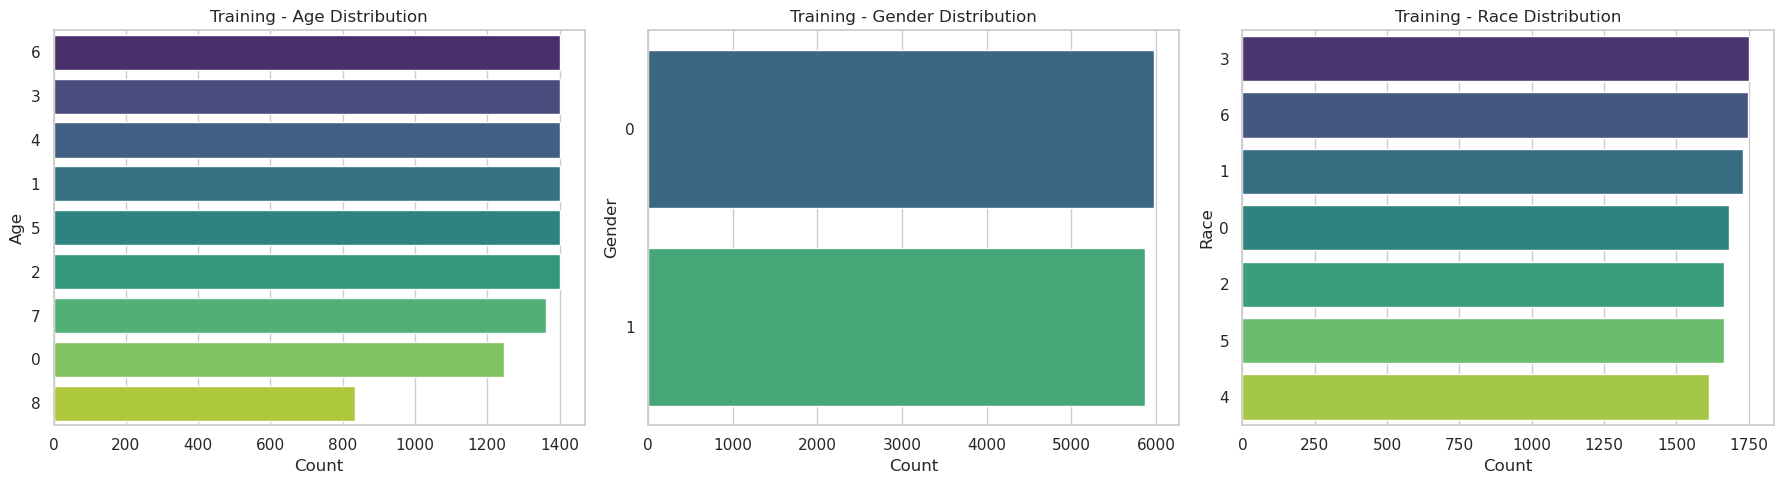


--- Label Distributions for Split: validation ---


/tmp/ipykernel_3658248/4185470159.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=labels_df, y=col, palette="viridis", order=labels_df[col].value_counts().index) # Use y for many categories
/tmp/ipykernel_3658248/4185470159.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=labels_df, y=col, palette="viridis", order=labels_df[col].value_counts().index) # Use y for many categories
/tmp/ipykernel_3658248/4185470159.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=labels_df, y=col, palette="viridis", order=labels

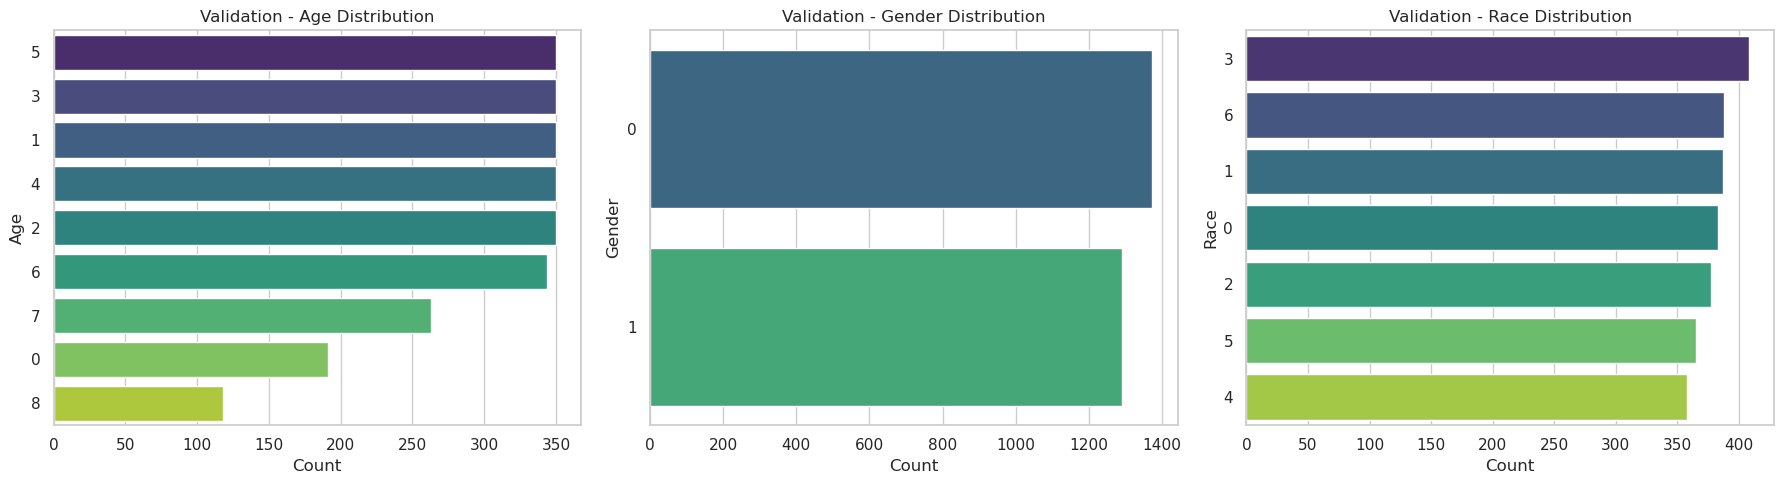

In [10]:
for split in data.keys():
    print(f"\n--- Label Distributions for Split: {split} ---")
    if 'labels_df' in data[split] and not data[split]['labels_df'].empty:
        labels_df = data[split]['labels_df']
        n_cols = len(EXPECTED_LABELS)
        plt.figure(figsize=(6 * n_cols, 5)) # Adjust figsize
        for i, col in enumerate(EXPECTED_LABELS):
            if col in labels_df.columns:
                plt.subplot(1, n_cols, i + 1)
                sns.countplot(data=labels_df, y=col, palette="viridis", order=labels_df[col].value_counts().index) # Use y for many categories
                plt.title(f"{split.capitalize()} - {col.capitalize()} Distribution")
                plt.xlabel("Count")
                plt.ylabel(col.capitalize())
                # Add counts on bars (optional)
                # for container in plt.gca().containers:
                #    plt.gca().bar_label(container, label_type='edge', padding=3)

        plt.tight_layout()
        plt.show()
    else:
        print(f"No labels DataFrame found for split '{split}' to analyze.")

**Interpretation:**
*   Observe the counts for each category within `age`, `gender`, and `race`.
*   Check if the distributions for the columns used in `STRATIFY_COLUMNS` (see file attributes) appear relatively balanced, as intended by the sampling strategy. Note that perfect balance isn't guaranteed if original strata were smaller than the target counts.
*   Compare the shapes of the distributions between the `training` and `validation` splits. Are they similar?

## 4. Analyze Label Relationships
Explore potential correlations between different label categories using cross-tabulations and heatmaps.


--- Label Relationships for Split: training ---


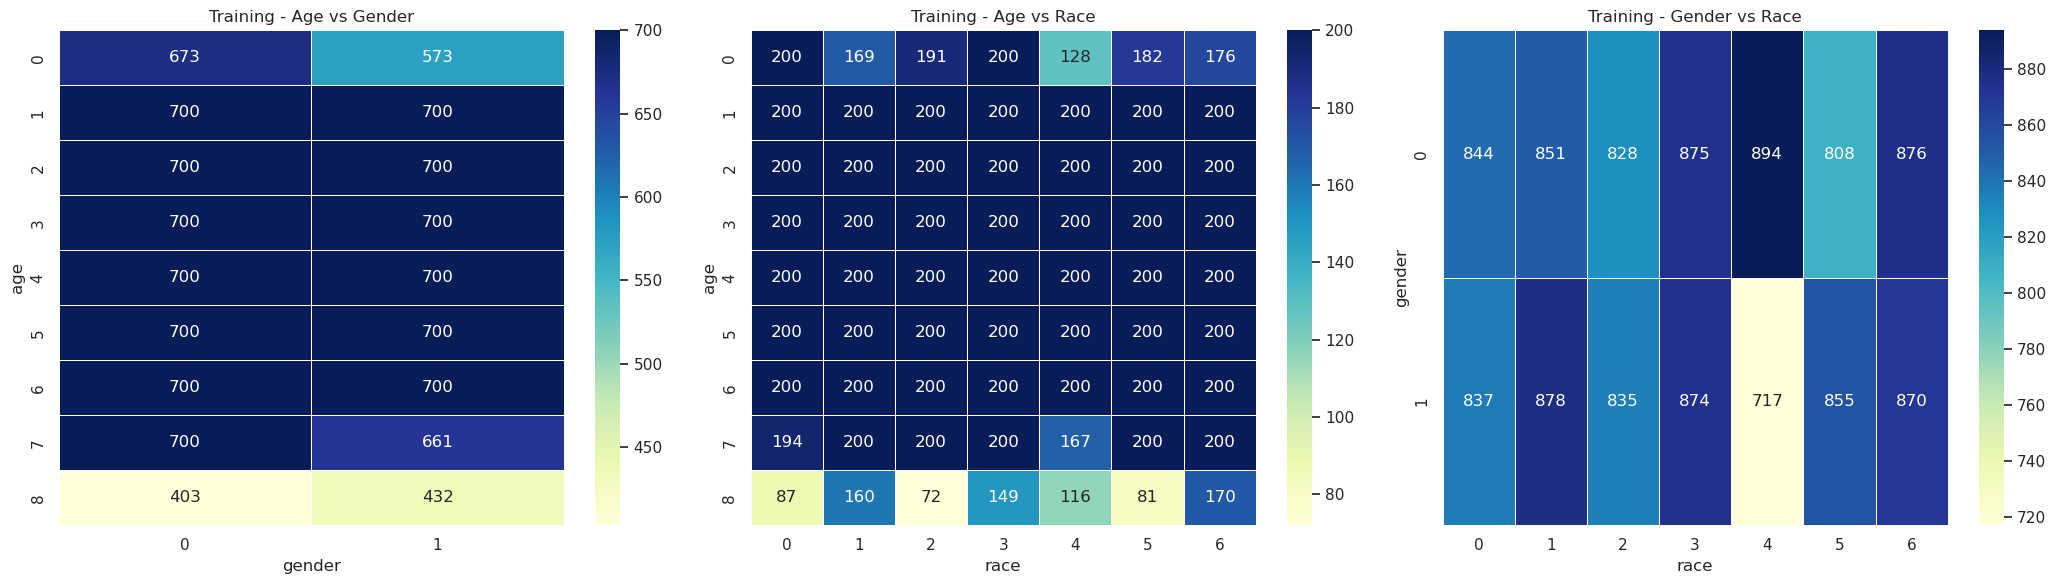


--- Label Relationships for Split: validation ---


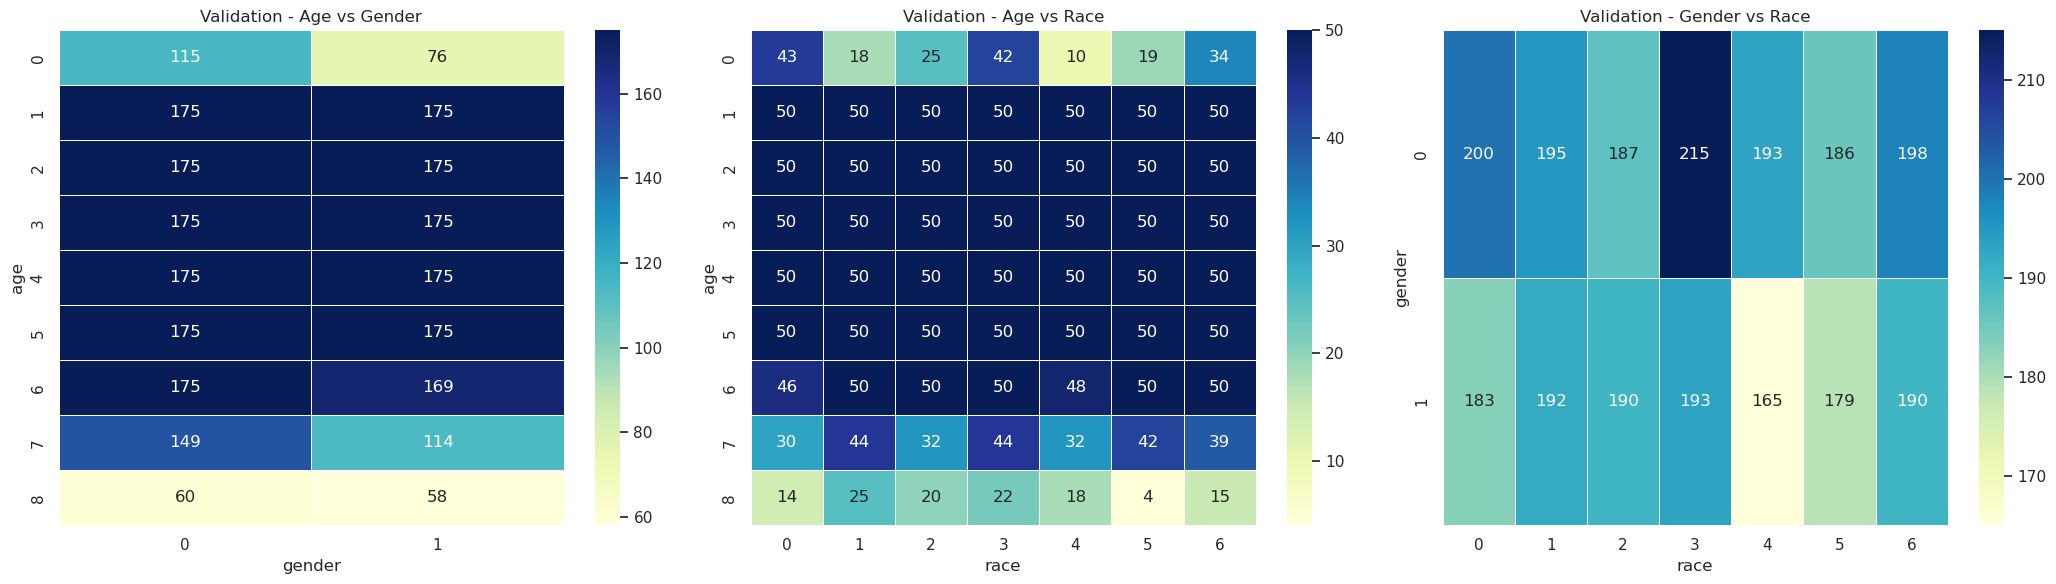

In [11]:
from itertools import combinations

for split in data.keys():
    print(f"\n--- Label Relationships for Split: {split} ---")
    if 'labels_df' in data[split] and not data[split]['labels_df'].empty:
        labels_df = data[split]['labels_df']
        label_pairs = list(combinations(EXPECTED_LABELS, 2))

        if not label_pairs:
            print("Need at least two label columns to compare relationships.")
            continue

        plt.figure(figsize=(7 * len(label_pairs), 6)) # Adjust figsize

        for i, (col1, col2) in enumerate(label_pairs):
            if col1 in labels_df.columns and col2 in labels_df.columns:
                plt.subplot(1, len(label_pairs), i + 1)
                crosstab = pd.crosstab(labels_df[col1], labels_df[col2])
                sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
                plt.title(f"{split.capitalize()} - {col1.capitalize()} vs {col2.capitalize()}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No labels DataFrame found for split '{split}' to analyze relationships.")

**Interpretation:**
*   Look at the heatmaps. Do certain combinations of labels (e.g., a specific race and gender) have noticeably higher or lower counts than others?
*   This can reveal intersectional biases or patterns present even within the stratified subset.

## 5. Analyze Encoded Features (Sample)
*(Optional)* Use dimensionality reduction (PCA or t-SNE) on
 a sample of the encoded features to visualize potential clustering based on labels. **Note:** This is computationally intensive and memory-dependent.


--- Encoded Feature Analysis (Sampled) for Split: training ---
  Flattened encoded sample shape: (1000, 443136)
  Running PCA...
  Explained variance ratio: [0.03971785 0.03566501]


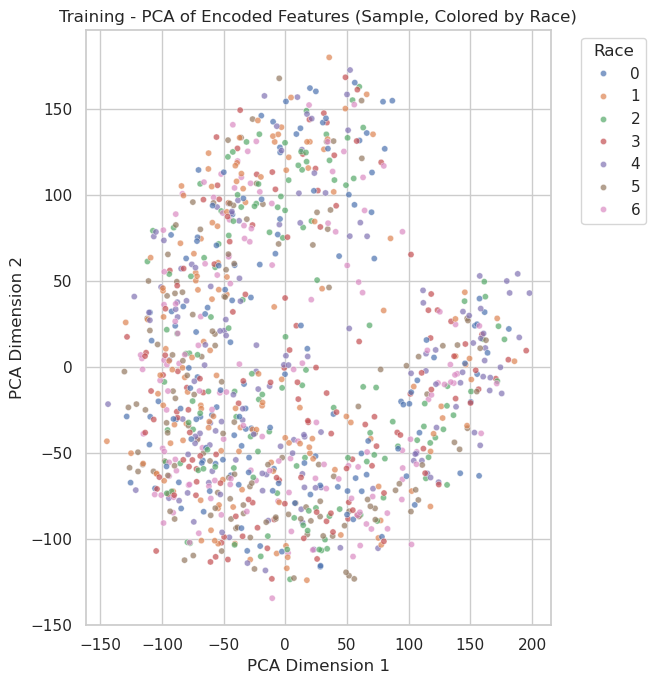


--- Encoded Feature Analysis (Sampled) for Split: validation ---
  Flattened encoded sample shape: (1000, 443136)
  Running PCA...
  Explained variance ratio: [0.0398078  0.03630786]


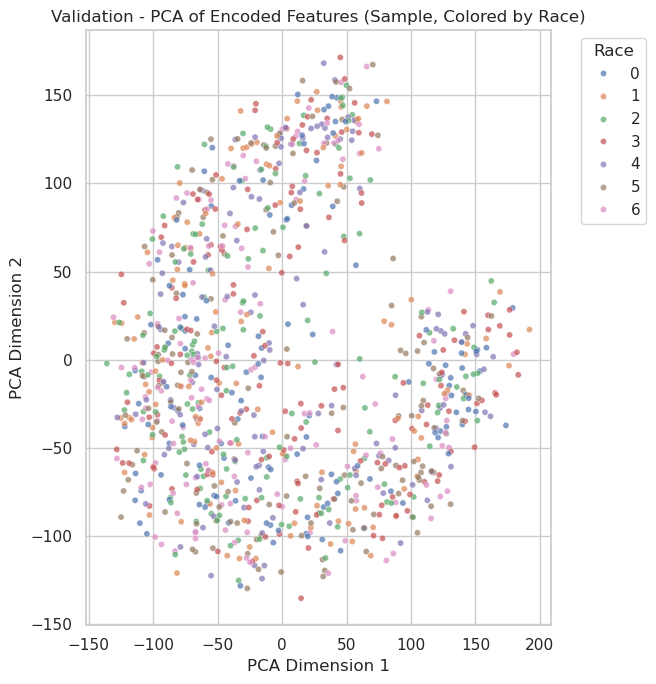

In [12]:
# --- Configuration for Encoded Feature Analysis ---
RUN_ENCODED_ANALYSIS = True # Set to False to skip this section
DIM_REDUCTION_METHOD = 'PCA' # 'PCA' or 'TSNE'

# --- Analysis ---
if RUN_ENCODED_ANALYSIS:
    for split in data.keys():
        print(f"\n--- Encoded Feature Analysis (Sampled) for Split: {split} ---")
        if 'encoded_sample' in data[split] and data[split]['encoded_sample'] is not None and \
           'labels_df_sample' in data[split] and data[split]['labels_df_sample'] is not None:

            encoded_sample = data[split]['encoded_sample']
            labels_sample_df = data[split]['labels_df_sample']

            # Ensure encoded_sample is float32 for PCA/t-SNE compatibility if it's float16
            if encoded_sample.dtype == np.float16:
                 encoded_sample = encoded_sample.astype(np.float32)

            # Flatten the features (Samples, SeqLen * Channels) -> (Samples, Features)
            n_samples = encoded_sample.shape[0]
            if encoded_sample.ndim > 2:
                 encoded_flat = encoded_sample.reshape(n_samples, -1)
                 print(f"  Flattened encoded sample shape: {encoded_flat.shape}")
            else:
                 encoded_flat = encoded_sample # Already flat or 2D

            if DIM_REDUCTION_METHOD == 'PCA':
                print("  Running PCA...")
                reducer = PCA(n_components=2, random_state=42)
                reduced_features = reducer.fit_transform(encoded_flat)
                print(f"  Explained variance ratio: {reducer.explained_variance_ratio_}")
            elif DIM_REDUCTION_METHOD == 'TSNE':
                 print("  Running t-SNE (can be slow)...")
                 # t-SNE parameters might need tuning (perplexity, learning_rate, n_iter)
                 reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, n_samples - 1), n_jobs=-1)
                 reduced_features = reducer.fit_transform(encoded_flat)
            else:
                 print(f"  Unknown dimensionality reduction method: {DIM_REDUCTION_METHOD}")
                 continue

            # Create DataFrame for plotting
            plot_df = pd.DataFrame({
                'Dim1': reduced_features[:, 0],
                'Dim2': reduced_features[:, 1]
            })
            # Add labels from the corresponding sample DataFrame
            for label_col in EXPECTED_LABELS:
                 if label_col in labels_sample_df.columns:
                     plot_df[label_col] = labels_sample_df[label_col].values # Ensure index alignment


            # Plot colored by a chosen label
            plot_label = 'race' # Choose which label to color by ('race', 'gender', 'age')
            if plot_label in plot_df.columns:
                plt.figure(figsize=(8, 7))
                sns.scatterplot(data=plot_df, x='Dim1', y='Dim2', hue=plot_label, palette='deep', s=20, alpha=0.7)
                plt.title(f"{split.capitalize()} - {DIM_REDUCTION_METHOD} of Encoded Features (Sample, Colored by {plot_label.capitalize()})")
                plt.xlabel(f"{DIM_REDUCTION_METHOD} Dimension 1")
                plt.ylabel(f"{DIM_REDUCTION_METHOD} Dimension 2")
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=plot_label.capitalize())
                plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout for legend
                plt.show()
            else:
                 print(f"  Label '{plot_label}' not found in sample DataFrame for plotting.")

        else:
            print(f"Skipping encoded feature analysis for '{split}': Data not loaded or empty.")
else:
    print("\nSkipping Encoded Feature Analysis as RUN_ENCODED_ANALYSIS is False.")

**Interpretation (Caution!):**
*   Does the scatter plot show any clear clusters corresponding to the different label categories (e.g., races)?
*   Keep in mind that 2D projections of high-dimensional data can be misleading. Lack of separation doesn't mean the information isn't there in higher dimensions, and apparent clusters might be projection artifacts.
*   This provides a very rough visual check. More sophisticated analysis is needed for firm conclusions about feature separability.

## 6. Qualitative Image Check (using Original Indices)
Load a few original images using the stored indices and compare them visually against the labels stored in the HDF5 file.


Loading original dataset: HuggingFaceM4/FairFace (0.25)...
  Original dataset loaded successfully.

--- Qualitative Image Check for Split: validation ---
  Checking 5 images...


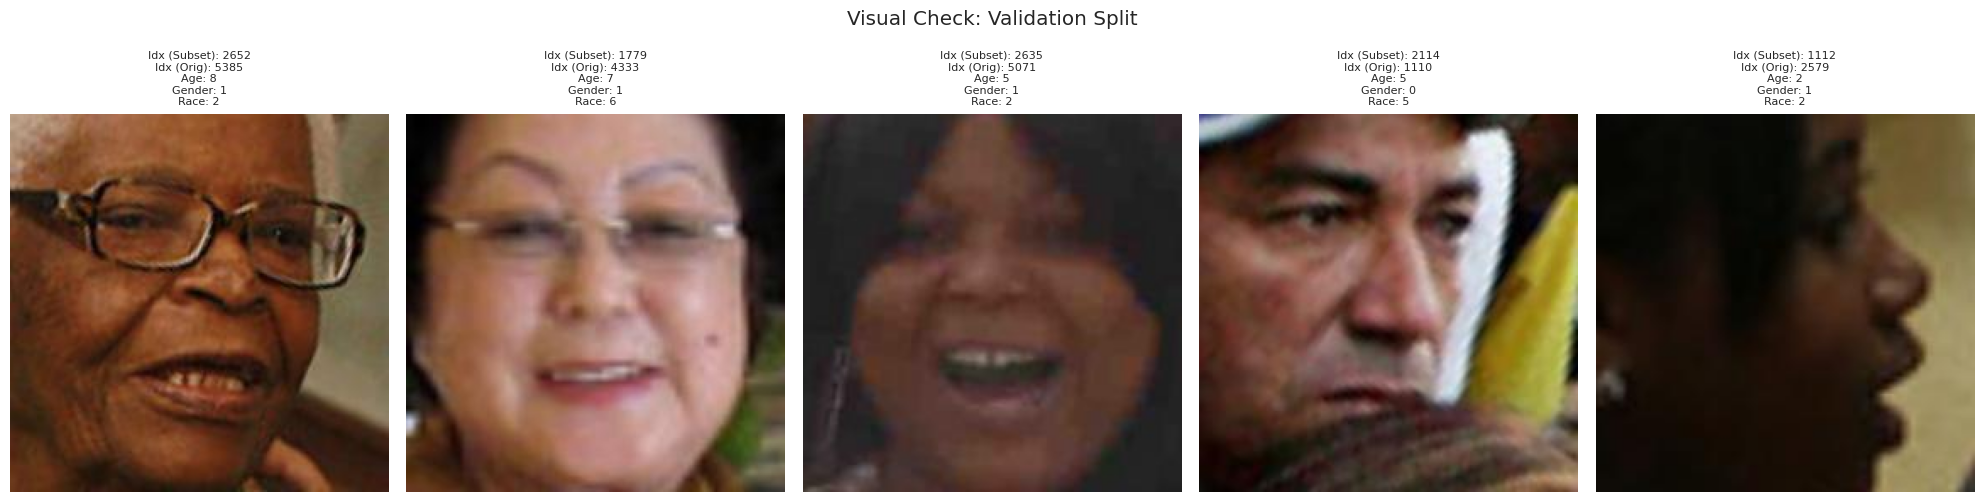

In [13]:
# --- Configuration ---
RUN_IMAGE_CHECK = True # Set to False to skip

# --- Load Original Dataset ---
original_dataset = None
if RUN_IMAGE_CHECK:
    try:
        print(f"\nLoading original dataset: {ORIG_DATASET_NAME} ({ORIG_DATASET_CONFIG})...")
        original_dataset = load_dataset(ORIG_DATASET_NAME, ORIG_DATASET_CONFIG, trust_remote_code=True) # Added trust_remote_code=True
        print("  Original dataset loaded successfully.")
    except Exception as e:
        print(f"  Failed to load original dataset: {e}. Skipping image check.")
        RUN_IMAGE_CHECK = False

# --- Perform Check ---
if RUN_IMAGE_CHECK and original_dataset:
    check_split = 'validation' # Choose which split to check ('training' or 'validation')

    if check_split in data and 'original_indices' in data[check_split] and data[check_split]['original_indices'] is not None and \
       'labels_df' in data[check_split] and not data[check_split]['labels_df'].empty:

        print(f"\n--- Qualitative Image Check for Split: {check_split} ---")

        indices_hdf5 = data[check_split]['original_indices']
        labels_hdf5_df = data[check_split]['labels_df']
        original_split_data = original_dataset[check_split] # Access the correct split

        if len(indices_hdf5) == 0:
             print("  No indices found in HDF5 to perform check.")
        else:
             # Select random indices FROM THE SUBSET's range
             subset_indices_to_check = np.random.choice(len(indices_hdf5), size=min(N_IMAGE_CHECKS, len(indices_hdf5)), replace=False)

             # Get the corresponding original indices and HDF5 labels
             original_indices_to_select = indices_hdf5[subset_indices_to_check]
             labels_to_display = labels_hdf5_df.iloc[subset_indices_to_check]

             print(f"  Checking {len(subset_indices_to_check)} images...")
             # Select items from the original dataset
             try:
                 selected_original_items = original_split_data.select(original_indices_to_select)
             except IndexError as e:
                  print(f"Error selecting indices from original dataset: {e}")
                  print(f"Max original index requested: {max(original_indices_to_select)}, Original dataset size: {len(original_split_data)}")
                  selected_original_items = None # Cannot proceed


             if selected_original_items:
                plt.figure(figsize=(4 * N_IMAGE_CHECKS, 5))
                for i, item_index in enumerate(subset_indices_to_check):
                    original_item = selected_original_items[i]
                    hdf5_labels = labels_to_display.iloc[i]

                    # Get image - handle potential errors/formats
                    img = None
                    try:
                        if isinstance(original_item['image'], Image.Image):
                             img = original_item['image']
                        elif isinstance(original_item['image'], dict) and 'bytes' in original_item['image'] and original_item['image']['bytes']:
                             img = Image.open(io.BytesIO(original_item['image']['bytes'])).convert("RGB")
                        elif isinstance(original_item['image'], str) and os.path.exists(original_item['image']):
                             img = Image.open(original_item['image']).convert("RGB")
                        else: # Attempt conversion
                             img = original_item['image'].convert("RGB")
                    except Exception as img_err:
                         print(f"Error loading image for subset index {item_index}: {img_err}")


                    plt.subplot(1, N_IMAGE_CHECKS, i + 1)
                    if img:
                         plt.imshow(img)
                    else:
                         plt.text(0.5, 0.5, 'Image Load Error', ha='center', va='center')

                    title = f"Idx (Subset): {item_index}\nIdx (Orig): {original_indices_to_select[i]}\n"
                    title += "\n".join([f"{key.capitalize()}: {val}" for key, val in hdf5_labels.items()])
                    plt.title(title, fontsize=8)
                    plt.axis('off')

                plt.suptitle(f"Visual Check: {check_split.capitalize()} Split", y=1.02)
                plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout for suptitle
                plt.show()

    else:
         print(f"Skipping image check for '{check_split}': Data (indices or labels) not loaded or empty.")
else:
    print("\nSkipping Qualitative Image Check.")

**Interpretation:**
*   Visually inspect the displayed images and compare them to the labels listed from the HDF5 file.
*   Do the labels (age, gender, race) appear consistent with the image content? This is a basic sanity check.

## 7. Summary & Conclusions
Briefly summarize the findings from the EDA.

*   **Structure:** The HDF5 file structure was confirmed, containing `encoded` features, `labels` (age, gender, race), and `original_indices` for both `training` and `validation` splits, along with relevant metadata attributes. Zstd compression was used.
*   **Label Distributions:** The distributions for age, gender, and race were visualized. We should note whether the stratified sampling appears to have successfully balanced the specified `STRATIFY_COLUMNS` relative to their original distributions and the target counts per stratum. Compare train/validation distributions - they should be similar if the same stratification strategy was applied. (Replace this with specific observations from your run).
*   **Label Relationships:** Cross-tabulations showed potential correlations (or lack thereof) between different demographic attributes within the subset. (Mention any specific strong relationships observed).
*   **Encoded Features:** (If run) Dimensionality reduction (PCA/t-SNE) provided a 2D visualization. Observations: (Describe any observed clustering or lack thereof, reiterating the limitations of 2D projection).
*   **Qualitative Check:** (If run) Visual inspection of N images confirmed consistency between the stored labels and the original image content accessed via the stored indices.
*   **Overall:** The dataset subset appears to be structured as intended. The label distributions reflect the stratified sampling approach. (Add any final thoughts or next steps based on the EDA).
